In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pyuvdata import UVData

The idea is that we are working from an existing data file, but we want a new one with controlled LST range.

In [3]:
uvd_raw = UVData()

In [4]:
uvd_raw.read('/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/Simulation/zen.2457755.69492.uvCP.uvh5')

In [5]:
# We'll do this differently, but for now just want to pick LSTs that lie within the range of the data file

In [6]:
uvd_raw.Ntimes

61

In [7]:
def jd_at_lst(uvdata, lst0):
    """ Given a UVData object, find the JD corresponding to the requested LST """
    jd = np.unique(uvdata.time_array)
    lst = np.unique(uvdata.lst_array)
    
    return np.interp(lst0, lst, jd)

In [8]:
lsts = np.unique(uvd_raw.lst_array)
jds = np.unique(uvd_raw.time_array)

In [9]:
pad = 30/3600.*2.*np.pi/24.

In [10]:
lst_min = lsts.min()+pad
lst_max = lsts.max()-pad

In [11]:
lst_where = np.logical_and(lsts < lst_max, lsts > lst_min)

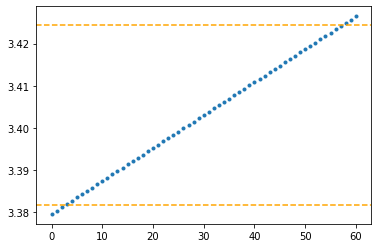

In [12]:
plt.plot(lsts,'.')
plt.axhline(lst_min,linestyle='--',color='orange')
plt.axhline(lst_max,linestyle='--',color='orange')

In [110]:
Ntimes = 50 # Picked by fiat; need a plan

In [45]:
""" You can set the LSTs from the time set_lsts_from_time_array, but here the whole point is to fix the LST, and then
get the corresponding JD.  I hope linear interpolation is sufficiently accurate. """
lsts_new = np.linspace(lst_min, lst_max, Ntimes)
jds_new = jd_at_lst(uvd_raw, lsts_new) 

In [46]:
# OK, this is going to be painful
# The required attributes are a method

In [145]:
for required in uvd_raw.required():
    print(required)

_Nants_data
_Nants_telescope
_Nbls
_Nblts
_Nfreqs
_Npols
_Nspws
_Ntimes
_ant_1_array
_ant_2_array
_antenna_names
_antenna_numbers
_antenna_positions
_baseline_array
_channel_width
_data_array
_flag_array
_freq_array
_history
_instrument
_integration_time
_lst_array
_nsample_array
_object_name
_phase_type
_polarization_array
_spw_array
_telescope_location
_telescope_name
_time_array
_uvw_array
_vis_units


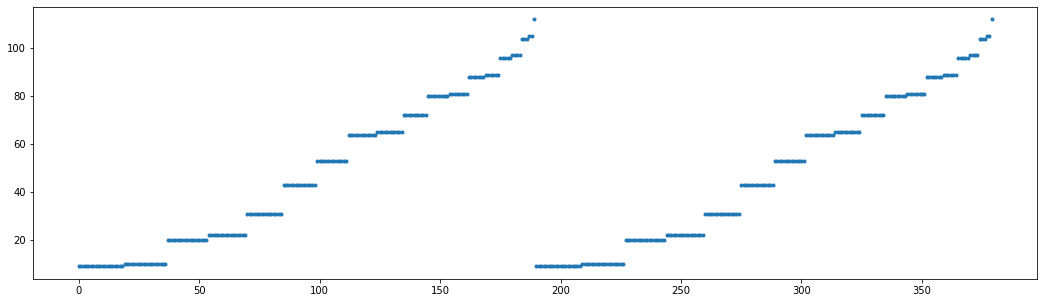

In [170]:
# Why in the living fuck does the antenna array need to know about the number of time samples
plt.figure(figsize=(18,5))
plt.plot(uvd_raw.ant_1_array[0:uvd_raw.Nbls*2],'.')
#plt.plot(uvd_raw.ant_2_array,'.')

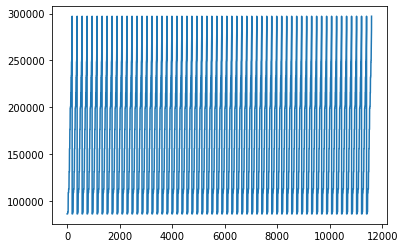

In [153]:
plt.plot(uvd_raw.baseline_array)

In [156]:
uvd_raw.antnums_to_baseline(9,10)

86027

In [109]:
# for some dumb reason, the attributes are returned with leading underscore
attributes = list(uvd_new.__dict__.keys())
print(attributes)
for i,attribute in enumerate(attributes):
    if attribute[0] == '_':
        attributes[i] = attribute[1:]
print()
print(attributes)

['_Ntimes', '_Nbls', '_Nblts', '_Nfreqs', '_Npols', '_data_array', '_vis_units', '_nsample_array', '_flag_array', '_Nspws', '_spw_array', '_uvw_array', '_time_array', '_lst_array', '_ant_1_array', '_ant_2_array', '_baseline_array', '_freq_array', '_polarization_array', '_integration_time', '_channel_width', '_object_name', '_telescope_name', '_instrument', '_telescope_location', '_history', '_phase_type', '_phase_center_epoch', '_phase_center_ra', '_phase_center_dec', '_phase_center_frame', '_Nants_data', '_Nants_telescope', '_antenna_names', '_antenna_numbers', '_antenna_positions', '_x_orientation', '_blt_order', '_extra_keywords', '_antenna_diameters', '_gst0', '_rdate', '_earth_omega', '_dut1', '_timesys', '_uvplane_reference_time', '_eq_coeffs', '_eq_coeffs_convention', 'pyuvdata_version_str']

['Ntimes', 'Nbls', 'Nblts', 'Nfreqs', 'Npols', 'data_array', 'vis_units', 'nsample_array', 'flag_array', 'Nspws', 'spw_array', 'uvw_array', 'time_array', 'lst_array', 'ant_1_array', 'ant_2_

In [173]:
Nbls = uvd_raw.Nbls
Nblts = Ntimes * Nbls
Nspws = uvd_raw.Nspws
Nfreqs = uvd_raw.Nfreqs
Npols = uvd_raw.Npols

In [174]:
data_array_new = np.zeros_like(uvd_raw.data_array, shape = [Nblts, Nspws, Nfreqs, Npols])
flag_array_new = np.zeros_like(uvd_raw.flag_array, shape = [Nblts, Nspws, Nfreqs, Npols])
nsample_array_new = np.ones_like(uvd_raw.nsample_array, shape = [Nblts, Nspws, Nfreqs, Npols])
uvw_array_new = np.zeros_like(uvd_raw.uvw_array, shape=[Nblts, 3])
time_array_new = np.zeros_like(uvd_raw.time_array, shape=[Nblts])
lst_array_new = np.zeros_like(uvd_raw.lst_array, shape=[Nblts])
ant_1_array_new = np.zeros_like(uvd_raw.ant_1_array, shape=[Nblts])
ant_2_array_new = np.zeros_like(uvd_raw.ant_2_array, shape=[Nblts])
baseline_array_new = np.zeros_like(uvd_raw.baseline_array, shape=[Nblts])
integration_time_new = np.zeros_like(uvd_raw.integration_time, shape=[Nblts])

In [163]:
np.array(uvd_raw.nsample_array.shape).prod()

47472640

In [166]:
np.array(uvd_raw.nsample_array).sum()

47472640.0

In [175]:
Nbls

190

In [177]:
# I just cannot figure out a way to do this that is BDA-proof ... maybe uvd_raw.resample_in_time?
# So we'll do it the stupid way
# There's probably a reshape that is smarter ...
for itime in np.arange(Ntimes):
    for ibl in np.arange(Nbls):
        indx = itime * Nbls + ibl
        # If in drift mode, they're all the same
        uvw_array_new[indx, :] = uvd_raw.uvw_array[0, :]
        time_array_new[indx] = jds_new[itime]
        lst_array_new[indx] = lsts_new[itime]
        # we're really assuming the pattern repeats every time sample ...
        ant_1_array_new[indx] = uvd_raw.ant_1_array[ibl]
        ant_2_array_new[indx] = uvd_raw.ant_2_array[ibl]          

In [178]:
# What do we need to change?
to_change = {'Ntimes' : Ntimes,
             'Nblts' : Nblts,
             'data_array' : data_array_new,
             'flag_array' : flag_array_new, # ... hoo boy
             'nsample_array' : nsample_array_new, # what?
             'uvw_array' : uvw_array_new, #... need to confirm we're drift scanning
             'time_array' : time_array_new, 
             'lst_array' : lst_array_new, 
             'integration_time' : integration_time_new,
             'ant_1_array' : ant_1_array_new, # why God, why?
             'ant_2_array' : ant_2_array_new,
             'baseline_array' : baseline_array_new # Oh, fuck my life
            }

In [189]:
uvd_new = UVData()
bl = (9, 10, 'ne')
for attribute in attributes:
    if attribute in to_change.keys():
        print('Changing '+attribute)
        setattr(uvd_new, attribute, to_change[attribute])
    else:
        print('Keeping '+attribute)
        setattr(uvd_new, attribute, getattr(uvd_raw, attribute))
    try:
        blt_ind1, blt_ind2, pol_ind = uvd_new._key2inds(bl)
        print('blt_ind1', blt_ind1.shape)
    except:
        print('Cannot get key2ind')
    #print(uvd_new.Ntimes)

Changing Ntimes
Cannot get key2ind
Keeping Nbls
Cannot get key2ind
Changing Nblts
Cannot get key2ind
Keeping Nfreqs
Cannot get key2ind
Keeping Npols
Cannot get key2ind
Changing data_array
Cannot get key2ind
Keeping vis_units
Cannot get key2ind
Changing nsample_array
Cannot get key2ind
Changing flag_array
Cannot get key2ind
Keeping Nspws
Cannot get key2ind
Keeping spw_array
Cannot get key2ind
Changing uvw_array
Cannot get key2ind
Changing time_array
Cannot get key2ind
Changing lst_array
Cannot get key2ind
Changing ant_1_array
Cannot get key2ind
Changing ant_2_array
Cannot get key2ind
Changing baseline_array
Cannot get key2ind
Keeping freq_array
Cannot get key2ind
Keeping polarization_array
Cannot get key2ind
Changing integration_time
Cannot get key2ind
Keeping channel_width
Cannot get key2ind
Keeping object_name
Cannot get key2ind
Keeping telescope_name
Cannot get key2ind
Keeping instrument
Cannot get key2ind
Keeping telescope_location
Cannot get key2ind
Keeping history
Cannot get key2i

In [190]:
uvd_new.integration_time[:] = uvd_new._calc_single_integration_time()

In [193]:
uvd_new.baseline_array = uvd_new.antnums_to_baseline(uvd_new.ant_1_array, uvd_new.ant_2_array)

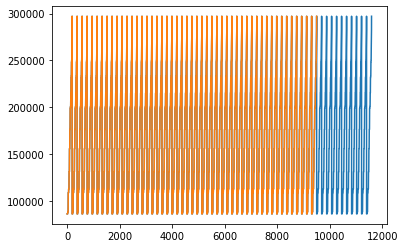

In [196]:
plt.plot(uvd_raw.baseline_array)
plt.plot(uvd_new.baseline_array)

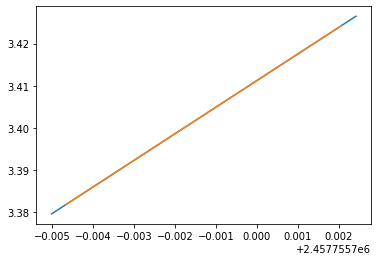

In [200]:
plt.plot(uvd_raw.time_array, uvd_raw.lst_array)
plt.plot(uvd_new.time_array, uvd_new.lst_array)

In [201]:
for huh in uvd_new.required():
    val = getattr(uvd_new, huh[1:])
    try:
        shape = val.shape
        print(huh, shape)
    except:
        print(huh, 'No shape')

_Nants_data No shape
_Nants_telescope No shape
_Nbls No shape
_Nblts No shape
_Nfreqs No shape
_Npols No shape
_Nspws No shape
_Ntimes No shape
_ant_1_array (9500,)
_ant_2_array (9500,)
_antenna_names No shape
_antenna_numbers (19,)
_antenna_positions (19, 3)
_baseline_array (9500,)
_channel_width No shape
_data_array (9500, 1, 1024, 4)
_flag_array (9500, 1, 1024, 4)
_freq_array (1, 1024)
_history No shape
_instrument No shape
_integration_time (9500,)
_lst_array (9500,)
_nsample_array (9500, 1, 1024, 4)
_object_name No shape
_phase_type No shape
_polarization_array (4,)
_spw_array (1,)
_telescope_location (3,)
_telescope_name No shape
_time_array (9500,)
_uvw_array (9500, 3)
_vis_units No shape


In [181]:
uvd_new.Nants_data == uvd_raw.Nants_data

True

In [217]:
from scipy.interpolate import CubicSpline

In [220]:
# OK, now go through baseline by baseline to fix up the changed data ..
for bl in uvd_new.get_antpairpols()[0:5]:
    print(bl)
    data = uvd_raw.get_data(bl)
    # There might not be a good way to handle flagging that differs in time between frequencies ...
    flags = uvd_raw.get_flags(bl)
    cs = CubicSpline(lsts, data, axis=0)
    interp = cs(lsts_new)

(9, 9, 'ee')
(9, 9, 'nn')
(9, 9, 'en')
(9, 9, 'ne')
(9, 10, 'ee')


In [215]:
def plot_raw_interp(data_raw, flags_raw, data_interp):
    plt.subplot(2,2,1)
    plt.imshow(data_raw.real/~flags_raw, aspect='auto')
    plt.subplot(2,2,2)
    plt.imshow(data_raw.imag/~flags_raw, aspect='auto')
    plt.subplot(2,2,3)
    plt.imshow(data_interp.real, aspect='auto')
    plt.subplot(2,2,4)
    plt.imshow(data_interp.imag, aspect='auto')
    plt.show()

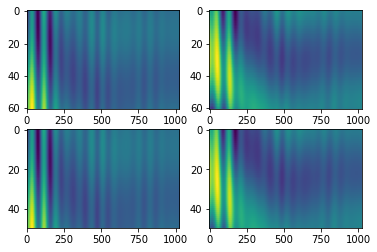

In [221]:
plot_raw_interp(data, flags, interp)

In [222]:
x = np.linspace(0,10,1000)

In [224]:
y = np.sin(2*np.pi*x/10.)

In [234]:
f = np.ones_like(x, dtype='bool')
f[np.array(np.random.uniform(low=0, high=1000, size=200),dtype='int16')] = False

In [237]:
f.shape

(1000,)

divide by zero encountered in true_divide


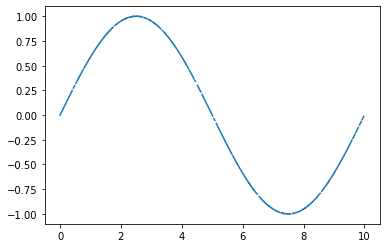

In [238]:
#plt.plot(x,y)
plt.plot(x,y/f)

In [239]:
cs_reg = CubicSpline(x,y)

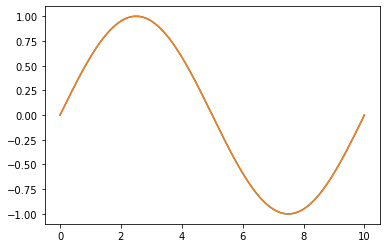

In [240]:
plt.plot(x,y)
plt.plot(x, cs_reg(x))

In [243]:
ynan = y.copy()
ynan[~f] = np.nan

In [244]:
cs_hm = CubicSpline(x,ynan)

ValueError: `y` must contain only finite values.